In [9]:
import pandas as pd
import numpy as np
# Load the data
data_path = 'cinema_daily_transactions.csv'
data = pd.read_csv(data_path)
data.head()

,not_happened_yet_date,monopoly_money_amount
0,2025-01-01,1078.0
1,2025-01-02,1092.0
2,2025-01-03,1181.0
3,2025-01-04,1166.0
4,2025-01-05,1083.0


In [14]:
data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'])

# Splitting the dataset into training and testing sets
train_data = data[data['not_happened_yet_date'].dt.month <= 9]
test_data = data[(data['not_happened_yet_date'].dt.month >= 10) & (data['not_happened_yet_date'].dt.month <= 11)]

train_data.to_csv('cinema_transactions_train.csv', index=False)
test_data.to_csv('cinema_transactions_test.csv', index=False)

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

train_data = pd.read_csv('cinema_transactions_train.csv')
test_data = pd.read_csv('cinema_transactions_test.csv')
# Convert the date column to datetime
train_data['not_happened_yet_date'] = pd.to_datetime(train_data['not_happened_yet_date'])
test_data['not_happened_yet_date'] = pd.to_datetime(train_data['not_happened_yet_date'])

# Set the date as the index
train_data.set_index('not_happened_yet_date', inplace=True)
test_data.set_index('not_happened_yet_date', inplace=True)

In [16]:
#Data pre-processing
# Find the zero value and replace it with the average of the day before and the day after
zero_value_date = train_data.index[train_data['monopoly_money_amount'] == 0]
if not zero_value_date.empty:
    for zero_date in zero_value_date:
        day_before = zero_date - pd.Timedelta(days=1)
        day_after = zero_date + pd.Timedelta(days=1)
        average_income = train_data.loc[[day_before, day_after], 'monopoly_money_amount'].mean()
        train_data.loc[zero_date, 'monopoly_money_amount'] = average_income

# Confirm the changes
train_data.head()


,monopoly_money_amount
not_happened_yet_date,
2025-01-01,1078.0
2025-01-02,1092.0
2025-01-03,1181.0
2025-01-04,1166.0
2025-01-05,1083.0


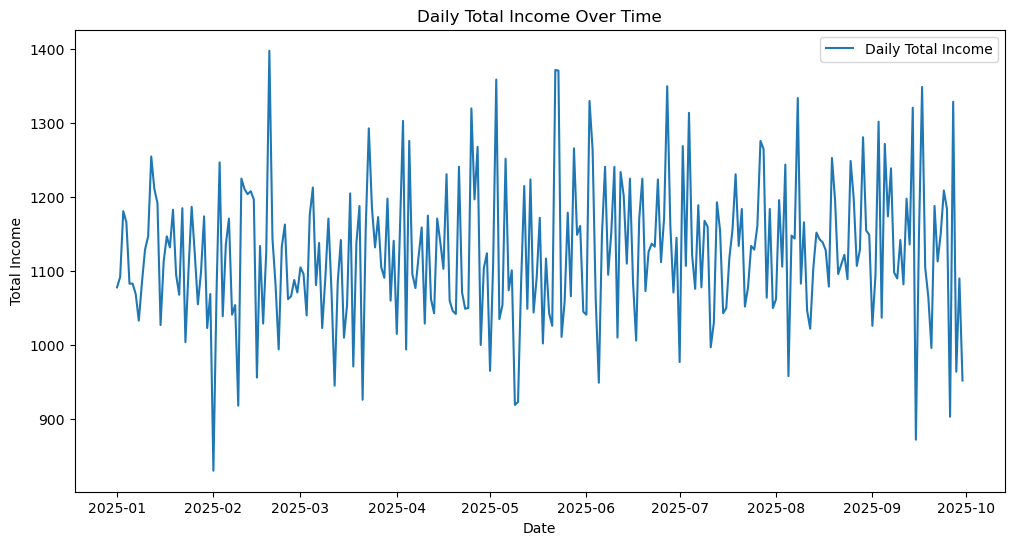

In [17]:
# Plot the daily total income
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['monopoly_money_amount'], label='Daily Total Income')
plt.title('Daily Total Income Over Time')
plt.xlabel('Date')
plt.ylabel('Total Income')
plt.legend()
plt.show()

In [18]:
#ADF test
# Perform Augmented Dickey-Fuller test to check for stationarity
adf_result = adfuller(train_data['monopoly_money_amount'])

adf_result

(-13.582685998270053,
 2.1090211356347287e-25,
 1,
 271,
 {'1%': -3.4547128138328875,
  '5%': -2.8722649771800155,
  '10%': -2.5724850011573914},
 3068.2026082810034)

      lb_stat  lb_pvalue
10  11.452386   0.323375


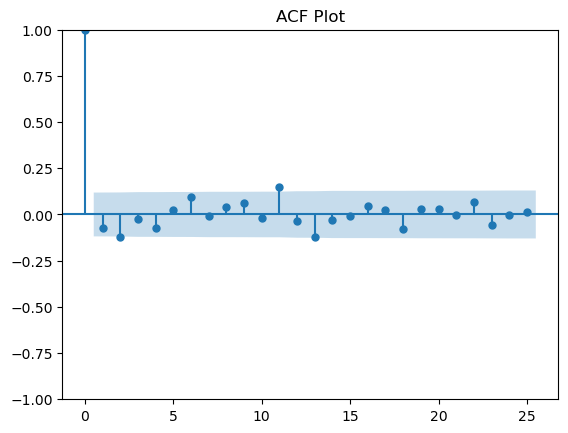

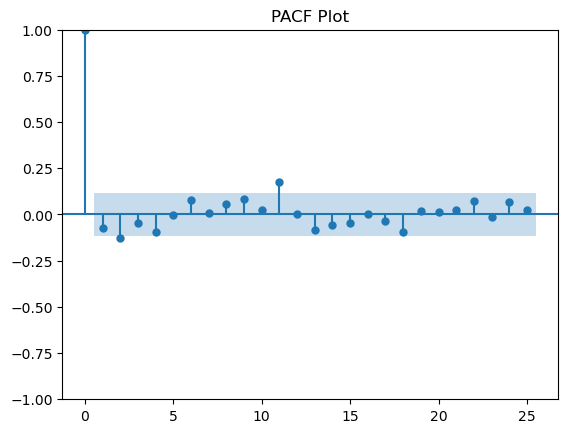

In [31]:
#Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(train_data, lags=[10], return_df=False)
print(lb_result)

# ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_data)
plt.title('ACF Plot')
plt.show()
plot_pacf(train_data)
plt.title('PACF Plot')
plt.show()

可以认为初始序列是白噪声，因此无法进行预测

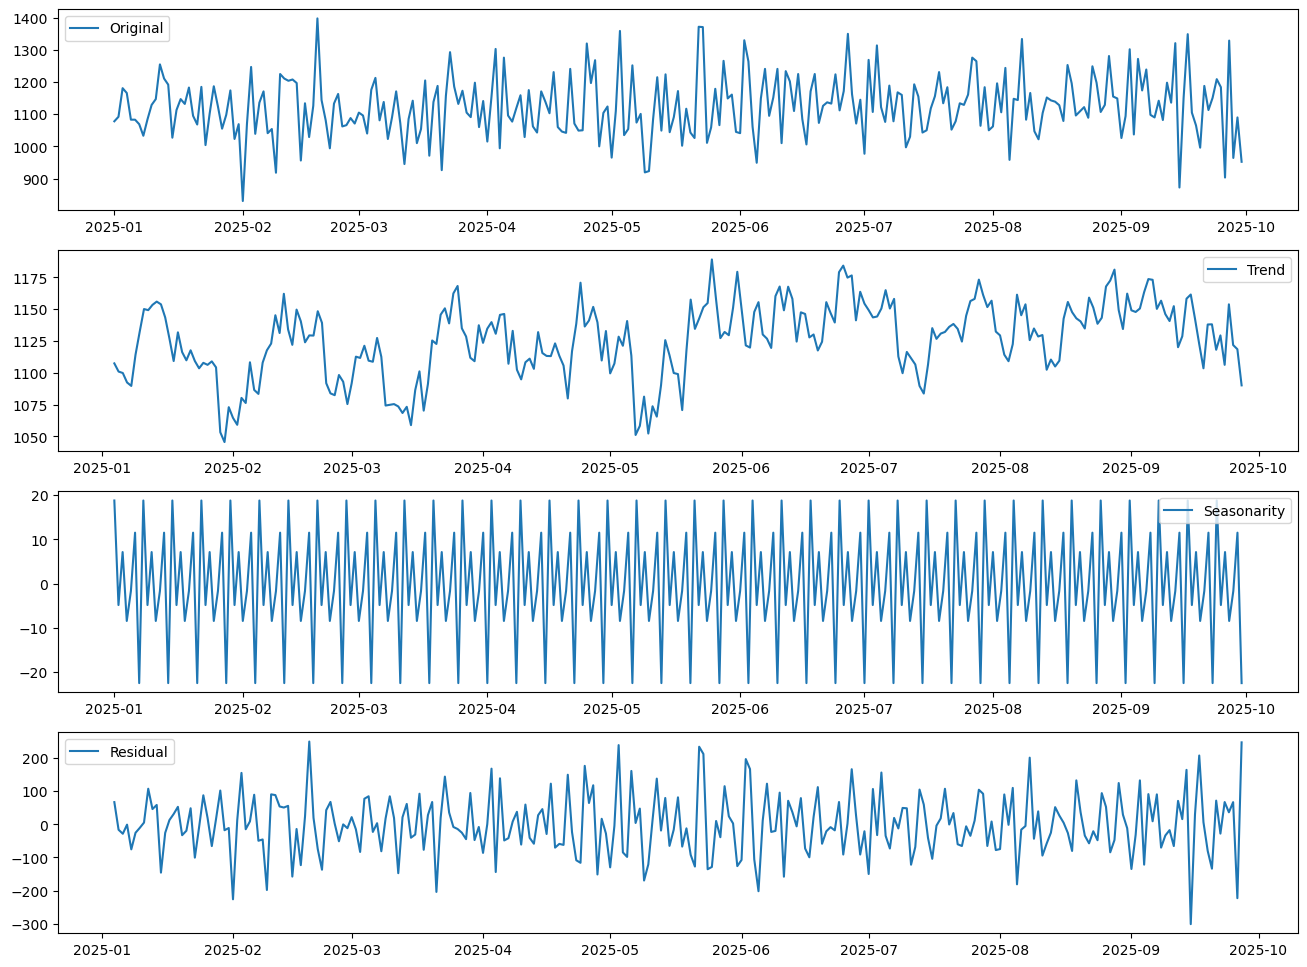

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF


def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()


# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
#                                  index_col='report_date', date_parser=dateparse)

decomposing(train_data)

从第三幅图能看出序列具有严格的季节性，但是其季节性波动对总体影响太小，因此白噪声检验时该序列被认为是白噪声